# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [2]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '19f24dd8e',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': 'C:\\Users\\Mercè\\anaconda3\\Lib\\site-packages\\IPython',
 'ipython_version': '8.20.0',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.22631-SP0',
 'sys_executable': 'c:\\Users\\Mercè\\anaconda3\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, '
                '18:05:47) [MSC v.1916 64 bit (AMD64)]'}


In [ ]:
%pip install -r "C:\Users\jesus\Desktop\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt" 

#"C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt"

In [8]:
# %pip install tensorflow[and-cuda]

In [ ]:
%pip install torchvision 

In [4]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

False


In [3]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3082392775972394149
xla_global_id: -1
]


In [5]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [22]:
# %pip install Pillow --upgrade

In [6]:
# globals

DATA_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input" # '/home/xnmaster/Project/input'
TRAIN_1_DIR =  r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\train_1\train_1" # '/home/xnmaster/Project/input/train_1'

# DATA_DIR = r"/Users/jesus/Desktop/Projecte/" 
# TRAIN_1_DIR =  r"/Users/jesus/Desktop/Projecte/train_1" 

# TRAIN_2_DIR = '../input/painters-train-part-1/train_2/train_2/'
# TRAIN_3_DIR = '../input/painters-train-part-1/train_3/train_3/'

# TRAIN_4_DIR = '../input/painters-train-part-2/train_4/train_4/'
# TRAIN_5_DIR = '../input/painters-train-part-2/train_5/train_5/'
# TRAIN_6_DIR = '../input/painters-train-part-2/train_6/train_6/'

# TRAIN_7_DIR = '../input/painters-train-part-3/train_7/train_7/'
# TRAIN_8_DIR = '../input/painters-train-part-3/train_8/train_8/'
# TRAIN_9_DIR = '../input/painters-train-part-3/train_9/train_9/'

# TRAIN_DIRS = [TRAIN_1_DIR, TRAIN_2_DIR, TRAIN_3_DIR,
#              TRAIN_4_DIR, TRAIN_5_DIR, TRAIN_6_DIR,
#              TRAIN_7_DIR, TRAIN_8_DIR, TRAIN_9_DIR]

TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\test\test" 

Execute in local and virtual
(no cal cada vegada, només una vegada pq elimina les fotos que no són vàlides)

In [17]:
from PIL import Image
import os

# Function to check if a file is an image
def is_image(file_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in image_extensions)

# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Invalid image: {file_path} - {e}")
        # Remove the file if it's invalid
        os.remove(file_path)
        print(f"Removed file: {file_path}")
        return False

# Validate images in a directory
def validate_images(directory):
    print(f"Validating images in directory: {directory}")
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and is_image(file_path):
            if is_valid_image(file_path):
                print(f"Valid image: {file_path}")

# Validate training and testing directories
def validate_directories(*directories):
    for directory in directories:
        if not os.path.exists(directory):
            raise ValueError(f"Directory does not exist: {directory}")
        if not os.path.isdir(directory):
            raise ValueError(f"Not a directory: {directory}")

# Validate training and testing directories
validate_directories(DATA_DIR, TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_directories(train_dir)

# Validate images in training and testing directories
validate_images(DATA_DIR)
validate_images(TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_images(train_dir)


Validating images in directory: /Users/jesus/Desktop/Projecte/
Validating images in directory: /Users/jesus/Desktop/Projecte/test
Validating images in directory: /Users/jesus/Desktop/Projecte/train_1
Valid image: /Users/jesus/Desktop/Projecte/train_1\1.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\10.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\1000.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\10000.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100001.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100002.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100003.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100006.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100007.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100009.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\10001.jpg
Valid image: /Users/jesus/Desktop/Projecte/train_1\100010.jpg
Valid imag

In [19]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_folder = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_folder)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_folder = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_folder)


Number of files in the folder TRAIN_1_DIR: 11025
Number of files in the folder TEST_DIR: 1


In [7]:
# df = pd.read_csv(DATA_DIR + 'all_data_info.csv/all_data_info.csv') 
df = pd.read_csv(DATA_DIR + r'\all_data_info\all_data_info.csv') # r'\train_info\train_info.csv'
print("df.shape", df.shape)

df.shape (103250, 12)


In [23]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [8]:
# quick fix for corrupted files
list_of_corrupted = ['3917.jpg','18649.jpg','20153.jpg','41945.jpg',
'79499.jpg','91033.jpg','92899.jpg','95347.jpg',
'100532.jpg','101947.jpg']
# display the corrupted rows of dataset for context
corrupt_df = df[df["new_filename"].isin(list_of_corrupted) == True]
print(corrupt_df.head(len(list_of_corrupted)))

# completely get rid of them
df = df[df["new_filename"].isin(list_of_corrupted) == False]

# try to see if they are still there
print(df[df["new_filename"].isin(list_of_corrupted) == True])

print("df.shape", df.shape)

                             artist    date              genre  pixelsx  \
185                  Giorgio Vasari    1534           portrait   3512.0   
731                       Juan Gris    1918          cityscape   2844.0   
994                       Juan Gris    1917         still life   3918.0   
1084   John Roddam Spencer Stanhope    1860     genre painting   4249.0   
1105                 Henri Rousseau    1908          cityscape   3403.0   
9984   John Roddam Spencer Stanhope     NaN  symbolic painting   1309.0   
19876              Georgia O'Keeffe  1915.0           abstract   1400.0   
28748                    Franz Marc    1913    animal painting    951.0   
46256           Esaias van de Velde    1622          landscape    942.0   
98236                 George Inness     NaN  literary painting    376.0   

       pixelsy  size_bytes     source                         style  \
185     4850.0  10360549.0    wikiart  Mannerism (Late Renaissance)   
731     3882.0   5393504.0    wi

Keep the works of artists who have a representation above 50%

In [9]:
# Step 1: Count occurrences of each artist
artist_counts = df['artist'].value_counts()

In [26]:
for artist in artist_counts:
    print(artist)

500
500
500
500
500
500
500
500
500
500
500
500
499
499
499
499
498
498
498
497
496
496
495
495
494
493
488
485
485
464
451
449
437
427
422
412
405
388
386
379
375
369
364
364
363
360
358
351
347
344
342
335
322
321
315
305
302
285
285
284
280
275
267
265
265
262
260
258
256
254
252
250
250
249
249
245
242
240
240
240
239
237
237
237
234
234
233
231
231
229
228
226
226
224
224
222
221
218
218
217
214
213
209
207
206
206
203
203
200
200
199
197
197
196
196
195
194
194
194
193
193
187
186
186
184
184
183
182
182
181
179
178
176
175
174
174
173
172
172
172
172
168
167
167
167
167
166
164
163
163
160
160
159
158
157
156
155
155
150
149
149
148
148
147
147
146
145
145
145
144
144
143
142
142
142
139
139
139
139
137
136
135
135
134
133
133
132
132
129
128
128
128
127
127
127
126
126
126
126
126
126
126
125
124
123
122
122
122
121
121
121
121
120
120
119
119
118
118
118
117
117
117
115
114
114
113
113
113
113
112
112
112
111
111
110
110
110
109
108
108
107
107
107
106
106
105
104
104
104
103


Above 499 artistic works

In [27]:
artists_above_499 = artist_counts[artist_counts >= 499].index
filtered_df = df[df['artist'].isin(artists_above_499)]

Above 199 artistic works

In [28]:
artists_above_99 = artist_counts[artist_counts >= 99].index
filtered_df = df[df['artist'].isin(artists_above_99)]

Keep files in directories of the filtered artists
(no executar si ja s'ha executat una vegada, si ja es té la carpeta nova)

In [29]:
import shutil


# Define the input folder
#input_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input"

input_folder = r"/Users/jesus/Desktop/Projecte"

# Define the output folder where you want to move the files
#output_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new"

output_folder = r"/Users/jesus/Desktop/Projecte/input_new"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over the rows in the filtered DataFrame
for index, row in filtered_df.iterrows():
    # Extract the new_filename from the DataFrame
    new_filename = row['new_filename']
    
    # Determine the subdirectory of the file (train_1 or test)
    source_subdirectory = "train_1" 
    # source_subdirectory = "test"

    # Search for the file in the input folder and its subdirectories
    for root, dirs, files in os.walk(os.path.join(input_folder, source_subdirectory)):
        if new_filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, new_filename)
            
            # Determine the destination subdirectory
            destination_subdirectory = os.path.join(output_folder, source_subdirectory)
            
            # Create the destination subdirectory if it doesn't exist
            os.makedirs(destination_subdirectory, exist_ok=True)
            
            # Define the destination path where you want to move the file
            destination_path = os.path.join(destination_subdirectory, new_filename)
            
            # Move the file to the output folder
            shutil.move(file_path, destination_path)


In [30]:
# Define the input folder
#input_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input"

input_folder = r"/Users/jesus/Desktop/Projecte"

# Define the output folder where you want to move the files
#output_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new"

output_folder = r"/Users/jesus/Desktop/Projecte/input_new"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over the rows in the filtered DataFrame
for index, row in filtered_df.iterrows():
    # Extract the new_filename from the DataFrame
    new_filename = row['new_filename']
    
    # Determine the subdirectory of the file (train_1 or test)
    # source_subdirectory = "train_1" 
    source_subdirectory = "test"

    # Search for the file in the input folder and its subdirectories
    for root, dirs, files in os.walk(os.path.join(input_folder, source_subdirectory)):
        if new_filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, new_filename)
            
            # Determine the destination subdirectory
            destination_subdirectory = os.path.join(output_folder, source_subdirectory)
            
            # Create the destination subdirectory if it doesn't exist
            os.makedirs(destination_subdirectory, exist_ok=True)
            
            # Define the destination path where you want to move the file
            destination_path = os.path.join(destination_subdirectory, new_filename)
            
            # Move the file to the output folder
            shutil.move(file_path, destination_path)


In [10]:
# globals

DATA_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new" # '/home/xnmaster/Project/input'
TRAIN_1_DIR =  r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new\train_1" # '/home/xnmaster/Project/input/train_1'

TRAIN_DIRS = [TRAIN_1_DIR]
TEST_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new\test" # '/home/xnmaster/Project/input/test'

# ATA_DIR = r"/Users/jesus/Desktop/Projecte/input_new" 
# TRAIN_1_DIR =  r"/Users/jesus/Desktop/Projecte/input_new/train_1" 

# TRAIN_DIRS = [TRAIN_1_DIR]
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/input_new/test" 

In [32]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_folder = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_folder)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_folder = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_folder)


Number of files in the folder TRAIN_1_DIR: 6288
Number of files in the folder TEST_DIR: 13455


Artists

In [11]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

artists = {} # holds artist hash & the count
for a in train_df['artist']:
    if (a not in artists):
        artists[a] = 1
    else:
        artists[a] += 1

training_set_artists = []
for a,count in artists.items():
    if(int(count) >= 200): # it takes no more than 200 artists
        training_set_artists.append(a)

print("number of artists",len(training_set_artists))

print("\nlist of artists...\n", training_set_artists)


test_df.shape (23814, 2)
train_df.shape (103240, 2)
number of artists 110

list of artists...
 ['Ivan Aivazovsky', 'Jan Matejko', 'Gustave Dore', 'Titian', 'Lucas Cranach the Elder', 'Utagawa Kuniyoshi', 'Odilon Redon', 'William Turner', 'Henri de Toulouse-Lautrec', 'Konstantin Somov', 'Thomas Eakins', 'Gustave Caillebotte', 'Ferdinand Hodler', 'William-Adolphe Bouguereau', 'Rembrandt', 'Ernst Ludwig Kirchner', 'Joshua Reynolds', 'William Merritt Chase', 'Edgar Degas', 'Claude Monet', 'Theodor Severin Kittelsen', 'Valentin Serov', 'Felix Vallotton ', 'Pierre-Auguste Renoir', 'Albrecht Durer', 'Francisco Goya', 'Theophile Steinlen', 'Katsushika Hokusai', 'Tintoretto', 'Orest Kiprensky', 'Alfred Sisley', 'Ivan Bilibin', 'Berthe Morisot', 'Honore Daumier', 'Ivan Shishkin', 'Giovanni Battista Piranesi', 'Camille Corot', 'Childe Hassam', 'Raphael Kirchner', 'James Tissot', 'Giovanni Boldini', 'Vasily Vereshchagin', 'Niko Pirosmani', 'Eugene Boudin', 'Paul Cezanne', 'John Singer Sargent', 'P

In [12]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
25,Jan Matejko,75956.jpg
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg


In [13]:
t1_df = t_df[t_df['new_filename'].str.startswith('1')]

t2_df = t_df[t_df['new_filename'].str.startswith('2')]

t3_df = t_df[t_df['new_filename'].str.startswith('3')]

t4_df = t_df[t_df['new_filename'].str.startswith('4')]

t5_df = t_df[t_df['new_filename'].str.startswith('5')]

t6_df = t_df[t_df['new_filename'].str.startswith('6')]

t7_df = t_df[t_df['new_filename'].str.startswith('7')]

t8_df = t_df[t_df['new_filename'].str.startswith('8')]

t9_df = t_df[t_df['new_filename'].str.startswith('9')]

all_train_dfs = [t1_df, t2_df, t3_df,
                t4_df, t5_df, t6_df,
                t7_df, t8_df, t9_df]

t9_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
49,Utagawa Kuniyoshi,99733.jpg
51,Utagawa Kuniyoshi,93715.jpg
97,Ferdinand Hodler,96174.jpg
127,Joshua Reynolds,91879.jpg


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# specify the model that classifies 38 artists 🎨 🖌

## wandb
Execute following lines if we use wandb

In [ ]:
# %pip install wandb -qU

In [36]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()
# 0927244f833ccea1b247099feaaaf54084a5c30c

In [28]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7"
    # track hyperparameters and run metadata with wandb.config
    # config={
    #     "layer_1": 512,
    #     "activation_1": "softmax", # relu
    #     "dropout": random.uniform(0.01, 0.80),
    #     "layer_2": 10,
    #     # "activation_2": "softmax",
    #     "optimizer": "adam",
    #     "loss": "sparse_categorical_crossentropy",
    #     "metric": "accuracy",
    #     "epoch": 8,
    #     "batch_size": 256,
    # },
)

# [optional] use wandb.config as your config
# config = run.config


## without wandb

In [17]:
len(training_set_artists)

110

In [18]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

model_adam.layers[0].trainable = False

In [39]:
model_sgd = Sequential()

model_sgd.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_sgd.add(Dense(
  num_classes,
  activation='softmax'
))

model_sgd.layers[0].trainable = False

In [44]:
model_RMS = Sequential()
model_RMS.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_RMS.add(Dense(
  num_classes,
  activation='softmax'
))

model_RMS.layers[0].trainable = False

# Compile Model

## Adam

In [19]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

**Observation**
para un problema de clasificación binaria, a menudo se utiliza la 'entropía cruzada binaria', mientras que la 'entropía cruzada categórica' se utiliza para la clasificación de clases múltiples.
https://www.sourcetrail.com/es/pit%C3%B3n/keras/modelo-compilar-keras/

## SGD

In [41]:
model_sgd.compile(
  optimizer='sgd', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

## RMSprop

In [45]:
model_RMS.compile(optimizer ='RMSprop', 
              loss ='categorical_crossentropy', 
              metrics =['accuracy'])

# Setup the image data generator for each training directory 

In [20]:
# model globals
IMAGE_SIZE = 224
BATCH_SIZE = 96
TEST_BATCH_SIZE = 17 # because test has 23817 images and factors of 23817 are 3*17*467
                     # it is important that this number evenly divides the total num images 
VAL_SPLIT = 0.25

In [21]:
def setup_generators(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-"*20)
    if not preprocess_input:
          raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # setup resnet50 preprocessing 
    data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split)

    print(len(train_dataframe), "images in", train_dir, "and validation_split =", val_split)
    print("\ntraining set ImageDataGenerator")
    train_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        subset="training",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nvalidation set ImageDataGenerator")
    valid_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        subset="validation",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size,img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\ntest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False, # dont shuffle test directory
        class_mode=None,
        target_size=(img_size,img_size)
    )

    return (train_gen, valid_gen, test_gen)

print("defined setup_generators()")

defined setup_generators()


In [22]:
# delete some unused dataframes to free some RAM for training
del df
del t_df
del t1_df
del t2_df
del t3_df
del t4_df
del t5_df
del t6_df
del t7_df
del t8_df
del t9_df
gc.collect()

35

In [23]:
train_gens = [None]*len(TRAIN_DIRS)
valid_gens = [None]*len(TRAIN_DIRS)
test_gen  = None # only 1 test_gen
i = 0
for i in range(0, len(TRAIN_DIRS)):
    train_gens[i], valid_gens[i], test_gen = setup_generators(
        train_dataframe=all_train_dfs[i], train_dir=TRAIN_DIRS[i],
        val_split=VAL_SPLIT, img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, my_seed=MY_SEED, 
        list_of_classes=training_set_artists, test_dataframe=test_df, 
        test_dir=TEST_DIR, test_batch_size=TEST_BATCH_SIZE
    )
    i += 1

--------------------
5230 images in C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new\train_1 and validation_split = 0.25

training set ImageDataGenerator
Found 474 validated image filenames belonging to 110 classes.

validation set ImageDataGenerator
Found 157 validated image filenames belonging to 110 classes.


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 4599 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 4599 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(



test set ImageDataGenerator
Found 399 validated image filenames.


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 23415 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [24]:
MAX_EPOCHS = 5 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [25]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## wandb

In [37]:
%%wandb # per veure-ho en directe
hist_adam = model_adam.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/5


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0674 - loss: 4.5659

wandb: ERROR Unable to log learning rate.


5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 9s/step - accuracy: 0.0734 - loss: 4.4390 - val_accuracy: 0.0573 - val_loss: 4.5979
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.2676 - loss: 2.3320 - val_accuracy: 0.1529 - val_loss: 4.1692
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 106s 20s/step - accuracy: 0.4851 - loss: 1.5466 - val_accuracy: 0.1847 - val_loss: 3.0541
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 116s 21s/step - accuracy: 0.6812 - loss: 1.0419 - val_accuracy: 0.2166 - val_loss: 2.6339
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 113s 20s/step - accuracy: 0.7743 - loss: 0.7903 - val_accuracy: 0.2357 - val_loss: 2.9640


In [38]:
run.finish()

epoch/accuracy,▁▃▅▇█
epoch/epoch,▁▃▅▆█
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▆▂▁▂
epoch/accuracy,0.78903
epoch/epoch,4
epoch/loss,0.77206
epoch/val_accuracy,0.23567
epoch/val_loss,2.96397


## manual

In [52]:
histories_adam = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10


c:\Users\jesus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.0559 - loss: 4.9993 - val_accuracy: 0.1125 - val_loss: 5.3849
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 179s 6s/step - accuracy: 0.4324 - loss: 2.4576 - val_accuracy: 0.1906 - val_loss: 4.9035
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 179s 6s/step - accuracy: 0.6259 - loss: 1.6253 - val_accuracy: 0.2146 - val_loss: 4.7094
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.7524 - loss: 1.1537 - val_accuracy: 0.2188 - val_loss: 4.7550
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.8368 - loss: 0.8719 - val_accuracy: 0.2229 - val_loss: 4.7682


In [53]:
histories_sgd = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_sgd.append(
            model_sgd.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - accuracy: 0.0158 - loss: 5.2541 - val_accuracy: 0.0156 - val_loss: 5.4739
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.0929 - loss: 4.3344 - val_accuracy: 0.0427 - val_loss: 5.3192
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.1748 - loss: 3.8618 - val_accuracy: 0.0667 - val_loss: 5.1470
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 178s 6s/step - accuracy: 0.2160 - loss: 3.5053 - val_accuracy: 0.0854 - val_loss: 5.0569
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.2879 - loss: 3.1853 - val_accuracy: 0.1073 - val_loss: 4.9945


In [55]:
histories_RMS = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_RMS.append(
            model_RMS.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.0734 - loss: 4.8846 - val_accuracy: 0.1292 - val_loss: 5.0774
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 176s 6s/step - accuracy: 0.3772 - loss: 2.5824 - val_accuracy: 0.1813 - val_loss: 4.8887
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.5581 - loss: 1.7968 - val_accuracy: 0.2385 - val_loss: 4.7907
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.7165 - loss: 1.2754 - val_accuracy: 0.2302 - val_loss: 4.7755
STEP_SIZE_TRAIN 31
STEP_SIZE_VALID 10
31/31 ━━━━━━━━━━━━━━━━━━━━ 176s 6s/step - accuracy: 0.8056 - loss: 0.9334 - val_accuracy: 0.2229 - val_loss: 4.8784


# Evaluate the model 🧐 🤔

In [56]:
for history in histories_adam:
    print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [57]:
for history in histories_sgd:
    print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [58]:
for history in histories_RMS:
    print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [59]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

In [60]:
accuracies_sgd = []
val_accuracies_sgd = []
losses_sgd = []
val_losses_sgd = []
for hist in histories_sgd:
    if hist:
        accuracies_sgd += hist.history['accuracy']
        val_accuracies_sgd += hist.history['val_accuracy']
        losses_sgd += hist.history['loss']
        val_losses_sgd += hist.history['val_loss']

In [62]:
accuracies_RMS = []
val_accuracies_RMS = []
losses_RMS = []
val_losses_RMS = []
for hist in histories_RMS:
    if hist:
        accuracies_RMS += hist.history['accuracy']
        val_accuracies_RMS += hist.history['val_accuracy']
        losses_RMS += hist.history['loss']
        val_losses_RMS += hist.history['val_loss']

## Plots
### Accuracies

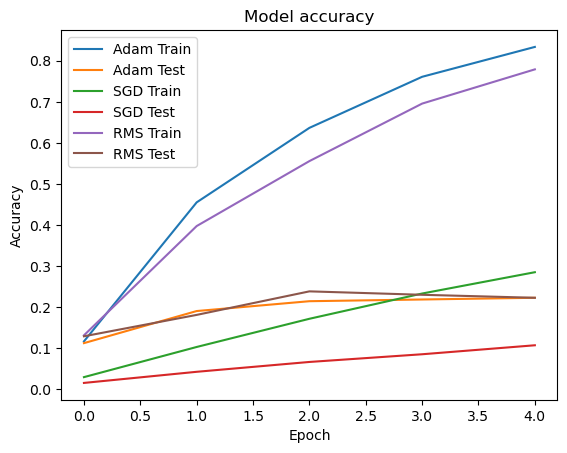

In [63]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.plot(accuracies_sgd, label = "SGD Train")
plt.plot(val_accuracies_sgd, label = "SGD Test")

plt.plot(accuracies_RMS, label = "RMS Train")
plt.plot(val_accuracies_RMS, label = "RMS Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [69]:
plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')

<Figure size 640x480 with 0 Axes>

### Loss values

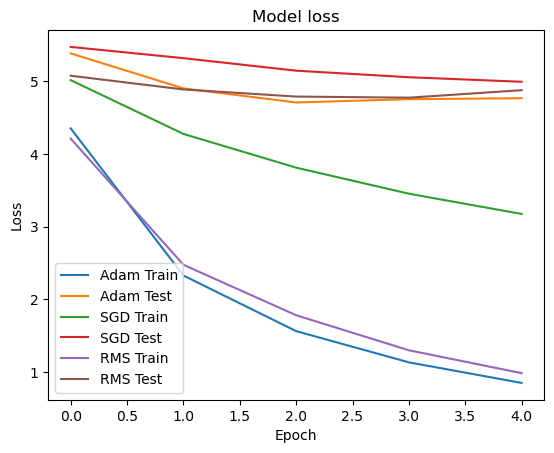

In [65]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.plot(losses_sgd, label = "SGD Train")
plt.plot(val_losses_sgd, label = "SGD Test")

plt.plot(losses_RMS, label = "RMS Train")
plt.plot(val_losses_RMS, label = "RMS Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [66]:
plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')

<Figure size 640x480 with 0 Axes>

In [76]:
# import time
# timestr = time.strftime("%Y%m%d-%H%M%S") # e.g: 20181109-180140
# model_adam.save('painters_adam_e45_'+timestr+'.h5')

In [ ]:
# timestr = time.strftime("%Y%m%d-%H%M%S") # e.g: 20181109-180140
# model_sgd.save('painters_adam_e45_'+timestr+'.h5')

# Predict the output 🔮 🎩

In [67]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

792

In [68]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

c:\Users\jesus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


792/792 ━━━━━━━━━━━━━━━━━━━━ 664s 832ms/step


In [70]:
print(len(pred_adam),"\n",pred_adam)

13455 
 [[3.00400221e-04 8.47472984e-06 4.12331519e-06 ... 4.94883687e-04
  7.38606923e-06 1.00275083e-05]
 [6.06930698e-05 2.77388608e-03 1.60919558e-02 ... 3.64669628e-04
  1.86728386e-07 1.60343276e-07]
 [3.30734765e-04 1.36672528e-02 1.23995699e-01 ... 7.37440307e-03
  7.24214544e-07 6.48476680e-06]
 ...
 [1.39962780e-04 7.03567115e-04 2.50825087e-06 ... 1.21571366e-02
  4.02204860e-05 4.88604885e-04]
 [1.04020706e-04 3.07576731e-03 2.29430116e-05 ... 8.32602564e-06
  7.12212059e-04 1.35097443e-05]
 [1.36397465e-03 1.11330432e-04 1.82187989e-06 ... 1.95028204e-02
  3.65967168e-07 6.52624522e-06]]


In [71]:
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

In [72]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

## Adam

In [73]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

13455 
 [ 88 102  95 ...  94  53  93]
it has values ranging from  0 ...to... 109
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'Jan Matejko': 1, 'Gustave Dore': 2, 'Titian': 3, 'Lucas Cranach the Elder': 4, 'Utagawa Kuniyoshi': 5, 'Odilon Redon': 6, 'William Turner': 7, 'Henri de Toulouse-Lautrec': 8, 'Konstantin Somov': 9, 'Thomas Eakins': 10, 'Gustave Caillebotte': 11, 'Ferdinand Hodler': 12, 'William-Adolphe Bouguereau': 13, 'Rembrandt': 14, 'Ernst Ludwig Kirchner': 15, 'Joshua Reynolds': 16, 'William Merritt Chase': 17, 'Edgar Degas': 18, 'Claude Monet': 19, 'Theodor Severin Kittelsen': 20, 'Valentin Serov': 21, 'Felix Vallotton ': 22, 'Pierre-Auguste Renoir': 23, 'Albrecht Durer': 24, 'Francisco Goya': 25, 'Theophile Steinlen': 26, 'Katsushika Hokusai': 27, 'Tintoretto': 28, 'Orest Kiprensky': 29, 'Alfred Sisley': 30, 'Ivan Bilibin': 31, 'Berthe Morisot': 32, 'Honore Daumier': 33, 'Ivan Shishkin': 34, 'Giovanni Battista Piranesi': 35, 'Camille Cor

In [74]:
results_adam.head()

,Filename,Predictions,Real Values
0,85864.jpg,Rene Magritte,Mark Rothko
1,75956.jpg,Konstantin Korovin,Jan Matejko
2,31977.jpg,Marc Chagall,Gustave Dore
3,2984.jpg,Norman Rockwell,Jean Fouquet
4,15715.jpg,Francisco Goya,Titian


In [75]:
len(training_set_artists)

110

In [76]:
print(training_set_artists)

['Ivan Aivazovsky', 'Jan Matejko', 'Gustave Dore', 'Titian', 'Lucas Cranach the Elder', 'Utagawa Kuniyoshi', 'Odilon Redon', 'William Turner', 'Henri de Toulouse-Lautrec', 'Konstantin Somov', 'Thomas Eakins', 'Gustave Caillebotte', 'Ferdinand Hodler', 'William-Adolphe Bouguereau', 'Rembrandt', 'Ernst Ludwig Kirchner', 'Joshua Reynolds', 'William Merritt Chase', 'Edgar Degas', 'Claude Monet', 'Theodor Severin Kittelsen', 'Valentin Serov', 'Felix Vallotton ', 'Pierre-Auguste Renoir', 'Albrecht Durer', 'Francisco Goya', 'Theophile Steinlen', 'Katsushika Hokusai', 'Tintoretto', 'Orest Kiprensky', 'Alfred Sisley', 'Ivan Bilibin', 'Berthe Morisot', 'Honore Daumier', 'Ivan Shishkin', 'Giovanni Battista Piranesi', 'Camille Corot', 'Childe Hassam', 'Raphael Kirchner', 'James Tissot', 'Giovanni Boldini', 'Vasily Vereshchagin', 'Niko Pirosmani', 'Eugene Boudin', 'Paul Cezanne', 'John Singer Sargent', 'Peter Paul Rubens', 'Vasily Surikov', 'Vincent van Gogh', 'Georges Braque', 'Eugene Delacroix', 

In [77]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

In [78]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists
3235 / 8691 = 0.3722
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 4764
0 / 4764 = 0.0000
test accuracy on new images
3235 / 13455 = 0.2404


## SGD

In [79]:
test_gen.reset()
pred_sgd = model_sgd.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_sgd),"\n",pred_sgd)

792/792 ━━━━━━━━━━━━━━━━━━━━ 608s 762ms/step
13455 
 [[3.4158055e-03 4.2372002e-04 8.3117984e-04 ... 5.7625736e-04
  3.0491204e-04 1.3453953e-03]
 [2.8090603e-03 3.0659642e-03 2.6941050e-02 ... 7.8183953e-03
  3.1302249e-04 3.1462978e-03]
 [7.0853473e-04 3.7531741e-03 6.7147166e-02 ... 8.0190096e-03
  7.3514151e-05 4.0201892e-04]
 ...
 [2.3586003e-03 2.6842926e-03 7.4076949e-04 ... 7.3355399e-03
  1.6601576e-02 2.4638812e-03]
 [3.6234275e-04 1.1432306e-02 5.0917215e-04 ... 6.3525810e-04
  4.6051727e-03 2.9453381e-03]
 [8.4592188e-03 4.9797250e-03 3.7919607e-03 ... 1.4990496e-02
  5.3942753e-03 2.2837711e-03]]


In [81]:
predicted_class_indices_sgd = np.argmax(pred_sgd,axis=1)

In [82]:
results_sgd = retrieve_results(predicted_class_indices_sgd, train_gens)
results_sgd.head()

13455 
 [ 73  36  26 ...  73 103  71]
it has values ranging from  0 ...to... 109
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'Jan Matejko': 1, 'Gustave Dore': 2, 'Titian': 3, 'Lucas Cranach the Elder': 4, 'Utagawa Kuniyoshi': 5, 'Odilon Redon': 6, 'William Turner': 7, 'Henri de Toulouse-Lautrec': 8, 'Konstantin Somov': 9, 'Thomas Eakins': 10, 'Gustave Caillebotte': 11, 'Ferdinand Hodler': 12, 'William-Adolphe Bouguereau': 13, 'Rembrandt': 14, 'Ernst Ludwig Kirchner': 15, 'Joshua Reynolds': 16, 'William Merritt Chase': 17, 'Edgar Degas': 18, 'Claude Monet': 19, 'Theodor Severin Kittelsen': 20, 'Valentin Serov': 21, 'Felix Vallotton ': 22, 'Pierre-Auguste Renoir': 23, 'Albrecht Durer': 24, 'Francisco Goya': 25, 'Theophile Steinlen': 26, 'Katsushika Hokusai': 27, 'Tintoretto': 28, 'Orest Kiprensky': 29, 'Alfred Sisley': 30, 'Ivan Bilibin': 31, 'Berthe Morisot': 32, 'Honore Daumier': 33, 'Ivan Shishkin': 34, 'Giovanni Battista Piranesi': 35, 'Camille Cor

,Filename,Predictions,Real Values
0,85864.jpg,Ilya Repin,Mark Rothko
1,75956.jpg,Camille Corot,Jan Matejko
2,31977.jpg,Theophile Steinlen,Gustave Dore
3,2984.jpg,Raphael Kirchner,Jean Fouquet
4,15715.jpg,Ilya Repin,Titian


In [83]:
print(len(training_set_artists))
print(training_set_artists)

110
['Ivan Aivazovsky', 'Jan Matejko', 'Gustave Dore', 'Titian', 'Lucas Cranach the Elder', 'Utagawa Kuniyoshi', 'Odilon Redon', 'William Turner', 'Henri de Toulouse-Lautrec', 'Konstantin Somov', 'Thomas Eakins', 'Gustave Caillebotte', 'Ferdinand Hodler', 'William-Adolphe Bouguereau', 'Rembrandt', 'Ernst Ludwig Kirchner', 'Joshua Reynolds', 'William Merritt Chase', 'Edgar Degas', 'Claude Monet', 'Theodor Severin Kittelsen', 'Valentin Serov', 'Felix Vallotton ', 'Pierre-Auguste Renoir', 'Albrecht Durer', 'Francisco Goya', 'Theophile Steinlen', 'Katsushika Hokusai', 'Tintoretto', 'Orest Kiprensky', 'Alfred Sisley', 'Ivan Bilibin', 'Berthe Morisot', 'Honore Daumier', 'Ivan Shishkin', 'Giovanni Battista Piranesi', 'Camille Corot', 'Childe Hassam', 'Raphael Kirchner', 'James Tissot', 'Giovanni Boldini', 'Vasily Vereshchagin', 'Niko Pirosmani', 'Eugene Boudin', 'Paul Cezanne', 'John Singer Sargent', 'Peter Paul Rubens', 'Vasily Surikov', 'Vincent van Gogh', 'Georges Braque', 'Eugene Delacroi

In [84]:
testing_new_images(results_sgd, training_set_artists)

test accuracy on new images for TRAINED artists
1683 / 8691 = 0.1936
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 4764
0 / 4764 = 0.0000
test accuracy on new images
1683 / 13455 = 0.1251


## RMSprop

In [85]:
test_gen.reset()
pred_RMS = model_RMS.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_RMS),"\n",pred_RMS)

792/792 ━━━━━━━━━━━━━━━━━━━━ 592s 744ms/step
13455 
 [[8.8815919e-05 3.3820834e-06 4.2455840e-06 ... 1.3187146e-04
  1.2272742e-05 1.2095777e-05]
 [2.9881081e-05 1.8028265e-03 1.6021436e-02 ... 2.4067289e-04
  6.2021797e-08 7.7588872e-08]
 [7.3561976e-05 2.5773359e-02 6.1068878e-02 ... 9.4120356e-04
  7.3249225e-08 7.9875588e-07]
 ...
 [1.0414920e-04 1.6599047e-03 3.7789508e-07 ... 1.8573694e-03
  5.9998831e-05 1.0412238e-04]
 [7.9395822e-06 1.3765954e-02 1.4429031e-05 ... 2.5405682e-06
  5.9347646e-04 5.0146700e-05]
 [7.9391291e-04 2.0894859e-04 1.0949428e-05 ... 9.6393861e-03
  6.3254610e-08 1.2141197e-05]]


In [86]:
predicted_class_indices_RMS = np.argmax(pred_RMS,axis=1)

In [87]:
results_RMS = retrieve_results(predicted_class_indices_RMS, train_gens)
results_RMS.head()

13455 
 [ 88 102  26 ...  94  53  85]
it has values ranging from  0 ...to... 109
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'Jan Matejko': 1, 'Gustave Dore': 2, 'Titian': 3, 'Lucas Cranach the Elder': 4, 'Utagawa Kuniyoshi': 5, 'Odilon Redon': 6, 'William Turner': 7, 'Henri de Toulouse-Lautrec': 8, 'Konstantin Somov': 9, 'Thomas Eakins': 10, 'Gustave Caillebotte': 11, 'Ferdinand Hodler': 12, 'William-Adolphe Bouguereau': 13, 'Rembrandt': 14, 'Ernst Ludwig Kirchner': 15, 'Joshua Reynolds': 16, 'William Merritt Chase': 17, 'Edgar Degas': 18, 'Claude Monet': 19, 'Theodor Severin Kittelsen': 20, 'Valentin Serov': 21, 'Felix Vallotton ': 22, 'Pierre-Auguste Renoir': 23, 'Albrecht Durer': 24, 'Francisco Goya': 25, 'Theophile Steinlen': 26, 'Katsushika Hokusai': 27, 'Tintoretto': 28, 'Orest Kiprensky': 29, 'Alfred Sisley': 30, 'Ivan Bilibin': 31, 'Berthe Morisot': 32, 'Honore Daumier': 33, 'Ivan Shishkin': 34, 'Giovanni Battista Piranesi': 35, 'Camille Cor

,Filename,Predictions,Real Values
0,85864.jpg,Rene Magritte,Mark Rothko
1,75956.jpg,Konstantin Korovin,Jan Matejko
2,31977.jpg,Theophile Steinlen,Gustave Dore
3,2984.jpg,Zinaida Serebriakova,Jean Fouquet
4,15715.jpg,Titian,Titian


In [88]:
print(len(training_set_artists))
print(training_set_artists)

110
['Ivan Aivazovsky', 'Jan Matejko', 'Gustave Dore', 'Titian', 'Lucas Cranach the Elder', 'Utagawa Kuniyoshi', 'Odilon Redon', 'William Turner', 'Henri de Toulouse-Lautrec', 'Konstantin Somov', 'Thomas Eakins', 'Gustave Caillebotte', 'Ferdinand Hodler', 'William-Adolphe Bouguereau', 'Rembrandt', 'Ernst Ludwig Kirchner', 'Joshua Reynolds', 'William Merritt Chase', 'Edgar Degas', 'Claude Monet', 'Theodor Severin Kittelsen', 'Valentin Serov', 'Felix Vallotton ', 'Pierre-Auguste Renoir', 'Albrecht Durer', 'Francisco Goya', 'Theophile Steinlen', 'Katsushika Hokusai', 'Tintoretto', 'Orest Kiprensky', 'Alfred Sisley', 'Ivan Bilibin', 'Berthe Morisot', 'Honore Daumier', 'Ivan Shishkin', 'Giovanni Battista Piranesi', 'Camille Corot', 'Childe Hassam', 'Raphael Kirchner', 'James Tissot', 'Giovanni Boldini', 'Vasily Vereshchagin', 'Niko Pirosmani', 'Eugene Boudin', 'Paul Cezanne', 'John Singer Sargent', 'Peter Paul Rubens', 'Vasily Surikov', 'Vincent van Gogh', 'Georges Braque', 'Eugene Delacroi

In [89]:
testing_new_images(results_RMS, training_set_artists)

test accuracy on new images for TRAINED artists
3171 / 8691 = 0.3649
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 4764
0 / 4764 = 0.0000
test accuracy on new images
3171 / 13455 = 0.2357


# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

In [91]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


In [92]:
image = Image.open(TEST_DIR + "\\" + row['Filename']) 

KeyError: 'Filename'

In [ ]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)

In [94]:
# Load the dataset
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10

# Create compositions
# Create compositions
for predicted_artist, group in grouped_data:
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_images = len(group)
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.truetype("arial.ttf", 20)
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        # Open the image file
        image = Image.open(TEST_DIR + "\\" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
